In [1]:
%matplotlib inline 

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

## Generate Data

In [2]:
def photon_counts(N, M, N_atom, N_photon, std, N_backg=100, lam_backg=1, plot=True):
    '''
    Generates positions of photon counts from the randomly placed atoms on a lattice and from Poissonian dark counts.
    
    Parameters
    ----------
    N : integer
        number of lattice sites along one direction (NxN)
    M: integer
        number of camera pixels per lattice site along one direction (MxM)
    N_atom: integer
        total number of atoms on the lattice
    std: float
        standard deviation of the Gaussian that is sampled from
    N_photons: integer
        number of photons sampled from an atom
    N_backg: integer
        number of samples drawn from the Poisson distribution for the background noise
    lam_back: float
        expectation interval of the Poisson dark count event
        
    Returns
    -------
    xloc, yloc = array
        x and y positions of all the photon counts
    '''
        
    #Randomly place atoms on the lattice
    atom_location = np.random.choice(np.arange(N*N), N_atom, replace=False) #pick atom position randomly from NxN array
    atom_location_index = (np.unravel_index(atom_location, (N,N)) - np.ones((2, N_atom))*((N-1)/2)) * M #convert the atom location number to x,y atom location index
    x_index = atom_location_index[0,:] #atoms x location
    y_index = atom_location_index[1,:] #atoms y location
    
    #Store actual occupation of the atoms for future comparison with the inferred one
    lims = np.arange(0, (N+1)*M, M) - (N*M)/2
    actual_lattice = np.zeros((N, N));
    for ny in range(N):
        for nx in range(N):
            actual_lattice[ny, nx] = np.sum(np.where((x_index > lims[nx]) & (x_index < lims[nx+1]) & (y_index > lims[-(ny+2)]) & (y_index < lims[-(ny+1)]), 1, 0))
        
    #For each atom sample photons from a Gaussian centered on the lattice site, combine the x,y positions of the counts
    x_loc = np.array([])
    y_loc = np.array([])
    for i in range(N_atom):
        xx, yy = np.random.multivariate_normal([x_index[i], y_index[i]], [[std, 0], [0, std]], N_photon).T #at each atom location sample N_photons from a Gaussian
        x_loc = np.concatenate((x_loc, xx)) #combine the sampled x-locations for each atom
        y_loc = np.concatenate((y_loc, yy)) #combine the sampled y-locations for each atom
        
    #Generate dark counts which is the background noise of the camera. Combine dark photon locations with scattered photon locations.
    CCD_x = np.arange(0, N*M, 0.2) - ((N*M)/2) #x-pixel locations
    CCD_y = np.arange(0, N*M, 0.2) - ((N*M)/2) #y-pixel locations
    dark_count = np.random.poisson(lam_backg, N_backg) #create dark counts sampling from a Poisson distribution, this gives numbers corresponding to number of dark counts
    dark_count_location_x = np.random.choice(CCD_x, np.sum(dark_count), replace=True) #pick a random x location for the dark counts
    dark_count_location_y = np.random.choice(CCD_y, np.sum(dark_count), replace=True) #pick a random y location for the dark counts
    x_loc = np.concatenate((x_loc, dark_count_location_x)) #combine the sampled x-locations from atoms and dark counts
    y_loc = np.concatenate((y_loc, dark_count_location_y)) #combine the sampled y-locations from atoms and dark counts
    
    #Plot the image (collected photons) on the camera.
    if plot:      
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1,1,1)
        im = plt.plot(x_loc, y_loc, 'ko', markersize=1) #plot counts
        ax.set_xticks(np.arange(0, (N+3)*M, M) - (((N+2)*M)/2)) #vertical lines as visual aid
        ax.set_yticks(np.arange(0, (N+3)*M, M) - (((N+2)*M)/2)) #horizontal lines as visual aid
        ax.grid(True, color="black")
        
    return actual_lattice, x_loc, y_loc

## Visualize Data

Wall time: 24.9 ms


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

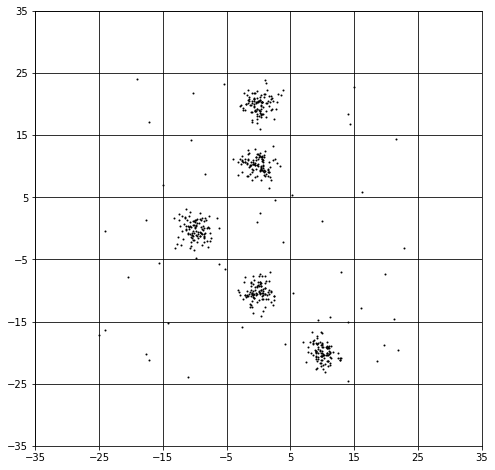

In [3]:
%time actual_lattice, x_loc, y_loc = photon_counts(N=5, M=10, N_atom=5, N_photon=100, std=2, N_backg=100, lam_backg=0.5, plot=True)
actual_lattice

## Mixture Model v0

In [64]:
def mixture_model(x, y, std, xsite, ysite):

    with pm.Model() as test_model:

        #Prior
        P = pm.Uniform('P', lower=0, upper=1)
        
        xc = (xsite[0]+xsite[1])/2 #x center of the site
        yc = (ysite[0]+ysite[1])/2 #y center of the site

        #Photons scattered from the atoms are Gaussian distributed
        atom_x = pm.Normal.dist(mu=xc, sigma=std).logp(x)
        atom_y = pm.Normal.dist(mu=yc, sigma=std).logp(y)
        atom = atom_x + atom_y
        
        #Photons from the camera background are uniform distributed
        background_x = pm.Uniform.dist(lower = xsite[0], upper = xsite[1]).logp(x)
        background_y = pm.Uniform.dist(lower = ysite[0], upper = ysite[1]).logp(y)
        background = background_x + background_y
        
        #Log-likelihood
        log_like = tt.log((P * tt.exp(atom) + (1-P) * tt.exp(background)))

        pm.Potential('logp', log_like.sum())
        
    map_estimate = pm.find_MAP(model=test_model)
    return map_estimate["P"][0]

In [65]:
def run_mixture_model(x_loc, y_loc, N, M, std):
    P_array = np.zeros((N,N))
    lims = np.arange(0, (N+1)*M, M) - (N*M)/2
    for ny in range(N):
        for nx in range(N):
            x = np.where((x_loc > lims[nx]) & (x_loc <= lims[nx+1]) & (y_loc > lims[-(ny+2)]) & (y_loc <= lims[-(ny+1)]), x_loc, np.pi)
            x_new = x[x != np.pi]
            y = np.where((x_loc > lims[nx]) & (x_loc <= lims[nx+1]) & (y_loc > lims[-(ny+2)]) & (y_loc <= lims[-(ny+1)]), y_loc, np.pi)
            y_new = y[y != np.pi]

            xsite = np.array([lims[nx], lims[nx+1]])
            ysite = np.array([lims[-(ny+2)], lims[-(ny+1)]])
            
            P_array[ny,nx] = mixture_model(x_new, y_new, std, xsite, ysite)
    return P_array

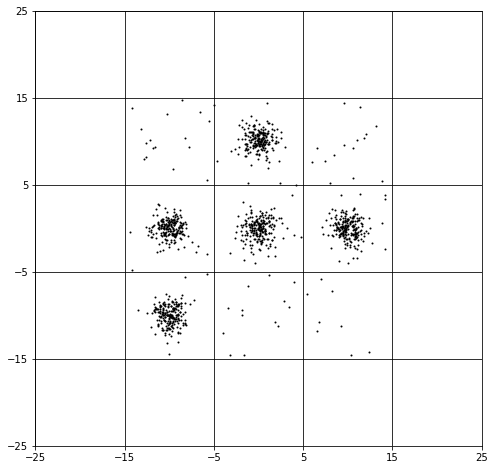

In [87]:
N = 3
M = 10
N_atom =5
N_photon = 200
std = 1

actual_lattice, x_loc, y_loc = photon_counts(N=N, M=M, N_atom=N_atom, N_photon=N_photon, std=std, N_backg=100, lam_backg=1, plot=True)

In [88]:
P = run_mixture_model(x_loc, y_loc, N, M, std) * 100

logp = -78.291, ||grad|| = 0.003565: 100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 7017.24it/s]
logp = -695.7, ||grad|| = 59.357: 100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 5009.92it/s]
logp = -68.87, ||grad|| = 2.7483: 100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 3509.88it/s]
logp = -682.08, ||grad|| = 62.986: 100%|█████████████████████████████████████████████| 11/11 [00:00<00:00, 5513.54it/s]
logp = -736.92, ||grad|| = 55.32: 100%|████████████████████████████████████████████████| 9/9 [00:00<00:00, 4511.62it/s]
logp = -733.97, ||grad|| = 59.679: 100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 3385.51it/s]
logp = -692.57, ||grad|| = 63.499: 100%|█████████████████████████████████████████████| 11/11 [00:00<00:00, 5515.52it/s]
logp = -59.87, ||grad|| = 0.0029955: 100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 4211.35it/s]
logp = -36.844, ||grad|| = 0.0023793: 10

In [89]:
np.set_printoptions(precision=1, suppress=True)
print(P)

[[ 0.  96.1 21.9]
 [96.6 92.9 93.6]
 [97.4  0.   0. ]]
